<a href="https://colab.research.google.com/github/Samir-Doghmi/Data_Science_Lab/blob/main/Time_Series_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this jupyter notebook predictive models on the historical series of daily e-commerce turnover will be implemented


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import itertools
import statsmodels.api as sm
from pmdarima.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score



### Building daily e-commerce

In [ ]:
ecommerce= pd.read_csv('C:/Users/glori/OneDrive/Desktop/3_DatasetFinale.csv', sep=",", encoding='latin-1')
for i in range(len(ecommerce)): #aggiungo la colonna Fatturato
    ecommerce.loc[i,"Fatturato"]=ecommerce.loc[i,'qta']*ecommerce.loc[i,'prezzo']

In [ ]:
ecommerce_giornaliero = ecommerce.groupby(['giorno', 'mese', 'anno']).agg(
    Fatturato=('Fatturato', 'sum'),
    numero_ordini=('giorno', 'count'),
    saldi=('saldi', 'first'),
    festa=('festa', 'first'),
    N_ricoveri=('N_ricoveri', 'first')
).reset_index().sort_values(['anno', 'mese', 'giorno'])

ecommerce_giornaliero['Data']=ecommerce_giornaliero['anno'].astype(str) + '-' + ecommerce_giornaliero['mese'].astype(str) + '-' + ecommerce_giornaliero['giorno'].astype(str).str.zfill(2)


**Time series plot**

Text(0, 0.5, 'Fatturato')

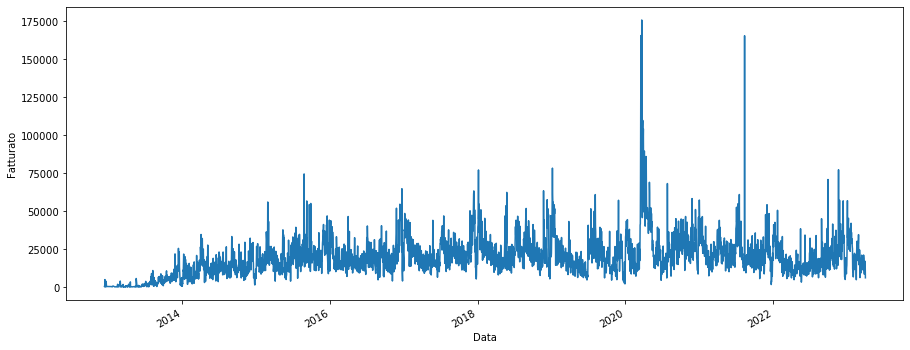

In [ ]:
new_data=ecommerce_giornaliero
new_data = new_data.set_index('Data')
new_data.index = pd.to_datetime(new_data.index)
y = new_data['Fatturato']
# Creo il grafico
y.plot(figsize=(15, 6))
plt.xlabel('Data')
plt.ylabel('Fatturato')

Verify that the time series is stationary in mean and in variance with the **Dickey-Fuller** test and **KPSS**

In [ ]:
result = adfuller(ecommerce_giornaliero['Fatturato'])
p_value = result[1]

if p_value < 0.05:
    print("La serie è stazionaria in media")
else:
    print("La serie non è stazionaria in media")

La serie è stazionaria in media


In [ ]:
# Esecuzione del test KPSS
result = kpss(ecommerce_giornaliero['Fatturato'])
p_value_kpss = result[1]
if p_value_kpss < 0.05:

    print("La serie è stazionaria in varianza")
else:
    print("La serie non è stazionaria in varianza")

La serie è stazionaria in varianza


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## ARIMAX

### Training the model


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

train_arimax, test_arimax = train_test_split(ecommerce_giornaliero, train_size=0.8)
p_values = range(0, 5)  # Valori possibili per p
q_values = range(0, 5)  # Valori possibili per q
d_values= (0,0,0)
param_combinations = list(itertools.product(p_values, d_values, q_values))
best_rmse = float('inf')  # Inizializza l'RMSE migliore come infinito
best_params = None  # Inizializza i migliori parametri come None
for params in param_combinations:
    try:
        print(params)
        model_ARIMAX = ARIMA(train_arimax['Fatturato'], order=((params[0], params[1], params[2])), exog=train_arimax[['N_ricoveri', 'festa', 'saldi']])
        model_ARIMAX_fit = model_ARIMAX.fit()
        predictions_ARIMAX=model_ARIMAX_fit.forecast(steps=len(test_arimax), exog=test_arimax[['N_ricoveri', 'festa', 'saldi']])
        rmse = mean_squared_error(test_arimax['Fatturato'], predictions_ARIMAX, squared=False)  # Calcola l'RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except:
        continue

#final_model = ARIMA(train['Fatturato'], order=((best_params[0], 0, best_params[1])), exog=train[['N_ricoveri', 'festa', 'saldi']]).fit()


(0, 0, 0)
(0, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\loca

(0, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 0)
(0, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 0)
(0, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(0, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(1, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(2, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(2, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(2, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(3, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(3, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(3, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(3, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 0)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 1)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

(4, 0, 2)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 3)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwar

(4, 0, 4)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Prediction on test data


In [ ]:
arimax = ARIMA(train_arimax['Fatturato'], order=((best_params[0], best_params[1], best_params[2])), exog=train_arimax[['N_ricoveri', 'festa', 'saldi']])

results_arimax = arimax.fit()
predictions_arimax = results_arimax.forecast(steps=len(test_arimax), exog=test_arimax[['N_ricoveri', 'festa', 'saldi']])

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\loca

In [ ]:
coeff = results_arimax.params
coeff_MA = results_arimax.maparams# Valore di phi per il termine ritardato Y(t-1)
print(coeff,coeff_MA)


const         1.796550e+04
N_ricoveri    1.740011e+00
festa        -9.174142e+02
saldi         2.632366e+03
ar.L1         4.060158e-01
ar.L2        -8.053035e-02
ar.L3         9.827067e-01
ar.L4        -3.176978e-01
ma.L1         1.457872e-01
ma.L2         2.427603e-01
ma.L3        -7.738534e-01
sigma2        6.807324e+07
dtype: float64 [ 0.14578722  0.24276033 -0.77385343]


### Prediction for the next month

In [ ]:
df = pd.DataFrame({
    'saldi': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Sostituisci con i valori dei saldi corrispondenti ai giorni desiderati
    'festa': [0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],  # Sostituisci con i valori delle festività corrispondenti ai giorni desiderati
    'N_ricoveri': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  # Sostituisci con i valori dei ricoveri corrispondenti ai giorni desiderati
})

previsione_futura_arimax=results_arimax.forecast(steps=len(df), exog=df[['N_ricoveri', 'festa', 'saldi']])
previsione_futura_arimax

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2929    24225.908184
2930    21426.740506
2931    21616.619909
2932    21256.474504
2933    20420.127870
2934    21185.445799
2935    21149.286722
2936    20365.508237
2937    21067.982213
2938    21137.642116
2939    20350.617974
2940    20047.380357
2941    20205.405903
2942    20341.976446
2943    20865.806998
2944    21101.542301
2945    20337.525655
2946    20771.183069
2947    21074.020202
2948    20336.357436
2949    19763.937352
2950    21040.656928
2951    20337.641276
2952    20596.652687
2953    21001.917422
2954    20340.594330
2955    19599.915155
2956    20958.312160
2957    20344.487281
2958    20443.531765
Name: predicted_mean, dtype: float64

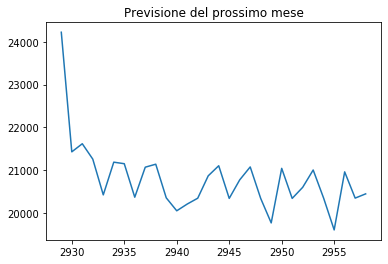

In [ ]:
ax=previsione_futura_arimax.plot()
ax.set_title('Previsione del prossimo mese')
plt.show()

#### Calculation of evaluation metrics

In [ ]:
# Calcolo delle metriche
mae_arimax = mean_absolute_error(test_arimax['Fatturato'], predictions_arimax)
mse_arimax = mean_squared_error(test_arimax['Fatturato'], predictions_arimax)
rmse_arimax = np.sqrt(mse_arimax)
mape_arimax = np.mean(np.abs((test_arimax['Fatturato'] - predictions_arimax) / test_arimax['Fatturato'])) * 100

#### Plot expected values vs observed values

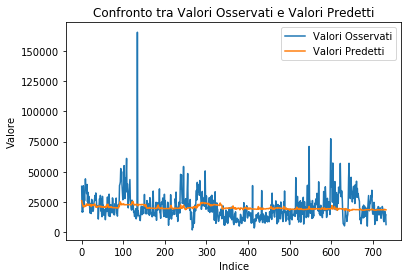

In [ ]:
import matplotlib.pyplot as plt


x = range(len(test_arimax))

# Plot dei valori osservati
plt.plot(x, test_arimax['Fatturato'], label='Valori Osservati')

# Plot dei valori predetti
plt.plot(x, predictions_arimax, label='Valori Predetti')

# Personalizzazione del grafico
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.title('Confronto tra Valori Osservati e Valori Predetti')
plt.legend()

# Mostrare il grafico
plt.show()

#### Residue analysis

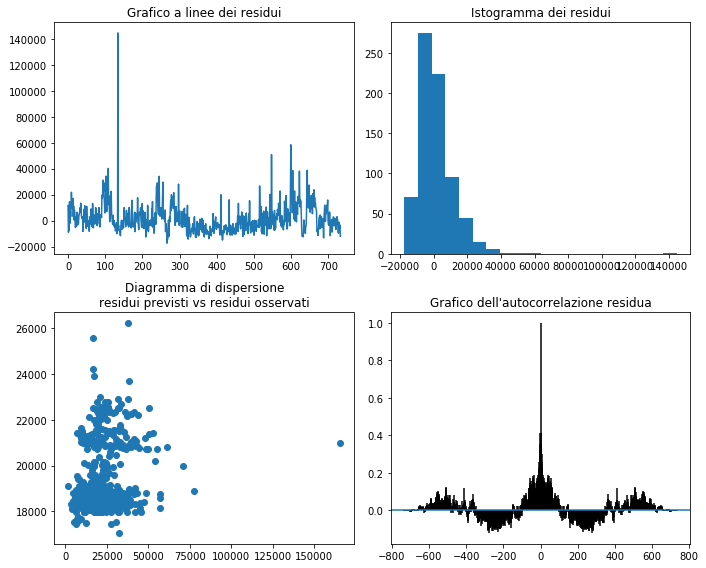

In [ ]:
attesi_arimax=test_arimax['Fatturato'].tolist()
predetti_arimax=predictions_arimax.tolist()
residui_arimax = [x - y for x, y in zip(attesi_arimax, predetti_arimax)]
import matplotlib.pyplot as plt
import scipy.stats



# Crea una figura e sottoplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico a linee dei residui
axs[0, 0].plot(residui_arimax)
axs[0, 0].set_title('Grafico a linee dei residui')

# Istogramma dei residui
axs[0, 1].hist(residui_arimax, bins=20)
axs[0, 1].set_title('Istogramma dei residui')

# Diagramma di dispersione residui previsti vs residui osservati
axs[1, 0].scatter(attesi_arimax, predetti_arimax)
axs[1, 0].set_title('Diagramma di dispersione\nresidui previsti vs residui osservati')

# Grafico dell'autocorrelazione residua
axs[1, 1].acorr(residui_arimax, maxlags=len(residui_arimax)-1)
axs[1, 1].set_title('Grafico dell\'autocorrelazione residua')




# Aggiusta la sovrapposizione tra i grafici
plt.tight_layout()

# Mostra il grafico
plt.show()


## XgBoost

### Training

In [ ]:
X = ecommerce_giornaliero[["festa", "N_ricoveri","saldi"]]  # Covariate
y = ecommerce_giornaliero["Fatturato"]  # Variabile target

X_train_XgBoost, X_test_XgBoost, y_train_XgBoost, y_test_XgBoost = train_test_split(X, y, test_size=0.2) #, random_state=42)
XgBoost = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=25, reg_alpha=0.01, reg_lambda=0.01)
XgBoost.fit(X_train_XgBoost, y_train_XgBoost)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Prediction of test values

In [ ]:
predictions_XgBoost = XgBoost.predict(X_test_XgBoost)

#### Future prediction for 30 days

In [ ]:
df = pd.DataFrame({
      # Sostituisci con i valori dei saldi corrispondenti ai giorni desiderati
    'festa': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],  # Sostituisci con i valori delle festività corrispondenti ai giorni desiderati
    'N_ricoveri': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'saldi': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],# Sostituisci con i valori dei ricoveri corrispondenti ai giorni desiderati
})
previsioni_future_xgboost=XgBoost.predict(df)
print(previsioni_future_xgboost)

[16165.389 16165.389 16165.389 16165.389 16165.389 16165.389 16165.389
 16165.389 16165.389 16165.389 16165.389 16165.389 16165.389 16165.389
 16165.389 16165.389 16165.389 16165.389 16165.389 16165.389 16016.82
 16165.389 16165.389 16165.389 16165.389 16165.389 16016.82  16165.389
 16165.389 19505.932]


In [ ]:
#previsioni_future_xgboost = pd.Series(previsioni_future_xgboost)
#ax=previsioni_future_xgboost.plot()
#ax.set_title('Previsione del prossimo mese')
#plt.show()

#### Comparison of observed values and expected values

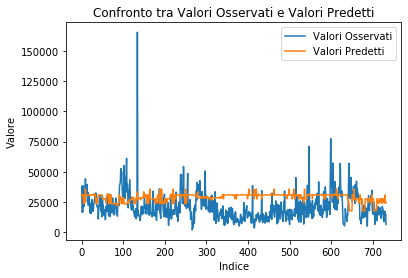

In [ ]:
import matplotlib.pyplot as plt

# Valori osservati

# Valori predetti

# Creazione degli indici per l'asse x
x = range(len(y_test_XgBoost))

# Plot dei valori osservati
plt.plot(x, y_test_XgBoost, label='Valori Osservati')

# Plot dei valori predetti
plt.plot(x, predictions_XgBoost, label='Valori Predetti')

# Personalizzazione del grafico
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.title('Confronto tra Valori Osservati e Valori Predetti')
plt.legend()

# Mostrare il grafico
plt.show()

#### Metrics calculation

In [ ]:
mae_XgBoost = mean_absolute_error(y_test_XgBoost, predictions_XgBoost)
mse_XgBoost = mean_squared_error(y_test_XgBoost, predictions_XgBoost)
rmse_XgBoost = np.sqrt(mse_XgBoost)
mape_XgBoost = np.mean(np.abs((y_test_XgBoost - predictions_XgBoost) / y_test_XgBoost)) * 100


#### Residual analysis

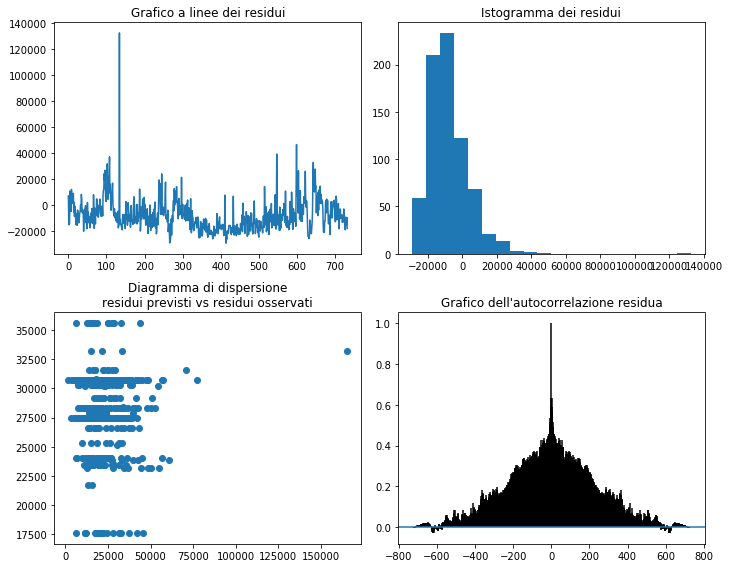

In [ ]:
attesi_XgBoost=y_test_XgBoost.tolist()
predetti_XgBoost=predictions_XgBoost.tolist()
residui_XgBoost = [x - y for x, y in zip(attesi_XgBoost, predetti_XgBoost)]
import matplotlib.pyplot as plt


# Crea una figura e sottoplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico a linee dei residui
axs[0, 0].plot(residui_XgBoost)
axs[0, 0].set_title('Grafico a linee dei residui')

# Istogramma dei residui
axs[0, 1].hist(residui_XgBoost, bins=20)
axs[0, 1].set_title('Istogramma dei residui')

# Diagramma di dispersione residui previsti vs residui osservati
axs[1, 0].scatter(attesi_XgBoost, predetti_XgBoost)
axs[1, 0].set_title('Diagramma di dispersione\nresidui previsti vs residui osservati')

# Grafico dell'autocorrelazione residua
axs[1, 1].acorr(residui_XgBoost, maxlags=len(residui_XgBoost)-1)
axs[1, 1].set_title('Grafico dell\'autocorrelazione residua')

# Aggiusta la sovrapposizione tra i grafici
plt.tight_layout()

# Mostra il grafico
plt.show()


#### Analysis of the importance of individual components


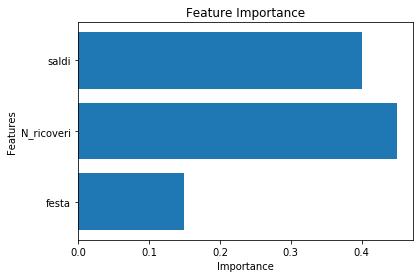

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Addestramento del modello XGBoost
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train_XgBoost, y_train_XgBoost)

# Calcolo dell'importanza delle feature
importance = xgboost.feature_importances_



# Creazione del grafico dell'importanza delle feature
plt.barh(range(len(importance)), importance, align='center')
plt.yticks(range(len(importance)), X_train_XgBoost.columns)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


#### Decision trees

In [ ]:
booster = XgBoost.get_booster()

# Estrai la lista degli alberi in formato stringa
tree_list = booster.get_dump()

# Stampa gli alberi
for i, tree in enumerate(tree_list):
    print(f"Albero {i+1}:")
    print(tree)
    print()

Albero 1:
0:[N_ricoveri<2690.5] yes=1,no=2,missing=1
	1:[N_ricoveri<192.5] yes=3,no=4,missing=3
		3:[saldi<1] yes=7,no=8,missing=7
			7:leaf=1756.60413
			8:leaf=2120.30151
		4:[N_ricoveri<2547] yes=9,no=10,missing=9
			9:leaf=3056.69238
			10:leaf=6587.7876
	2:[N_ricoveri<2714.5] yes=5,no=6,missing=5
		5:leaf=11976.8467
		6:leaf=16590.8594


Albero 2:
0:[N_ricoveri<2627.5] yes=1,no=2,missing=1
	1:[N_ricoveri<66] yes=3,no=4,missing=3
		3:[saldi<1] yes=7,no=8,missing=7
			7:leaf=1551.87732
			8:leaf=1900.81665
		4:[saldi<1] yes=9,no=10,missing=9
			9:leaf=2866.44897
			10:leaf=2226.5603
	2:[N_ricoveri<2690.5] yes=5,no=6,missing=5
		5:[N_ricoveri<2631] yes=11,no=12,missing=11
			11:leaf=15985.8662
			12:leaf=3740.34692
		6:[N_ricoveri<2714.5] yes=13,no=14,missing=13
			13:leaf=10791.0215
			14:leaf=14937.2861


Albero 3:
0:[N_ricoveri<2627.5] yes=1,no=2,missing=1
	1:[N_ricoveri<192.5] yes=3,no=4,missing=3
		3:[saldi<1] yes=7,no=8,missing=7
			7:leaf=1420.83484
			8:leaf=1716.50183
		4:[s

## Prophet

### Training

In [ ]:
from prophet import Prophet
# Creazione del DataFrame per il modello Prophet
df = pd.DataFrame({
    'ds': ecommerce_giornaliero['Data'],
    'y': ecommerce_giornaliero['Fatturato'],
    'festa': ecommerce_giornaliero['festa'],
    'saldi': ecommerce_giornaliero['saldi'],
    'N_ricoveri': ecommerce_giornaliero['N_ricoveri']
})

# Creazione del modello Prophet
prophet = Prophet()



# Aggiunta delle covariate al modello
prophet.add_regressor('festa')
prophet.add_regressor('saldi')
prophet.add_regressor('N_ricoveri')
train_size = int(len(df) * 0.8)  # Dimensione del set di addestramento (80% dei dati)
train_prophet = df[:train_size]  # Set di addestramento
test_prophet = df[train_size:]


#### Prediction on the test set

In [ ]:
# Addestramento del modello
prophet.fit(train_prophet)

#Previsione
forecast = prophet.predict(test_prophet)

16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:15 - cmdstanpy - INFO - Chain [1] done processing


#### Predictions for the next 30 days


In [ ]:
n_periods = 7

# Genera le date future
df = pd.DataFrame({
    'ds':['2023-04-05','2023-04-06','2023-04-07','2023-04-08','2023-04-09','2023-04-10','2023-04-11','2023-04-12',
          '2023-04-13','2023-04-14','2023-04-15','2023-04-16','2023-04-17','2023-04-18','2023-04-19','2023-04-20','2023-04-21',
         '2023-04-22','2023-04-23','2023-04-24','2023-04-25','2023-04-26','2023-04-27','2023-04-28','2023-04-29','2023-04-30','2023-05-01',
         '2023-05-02','2023-05-03','2023-05-04'],
    'saldi': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Sostituisci con i valori dei saldi corrispondenti ai giorni desiderati
    'festa': [0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],  # Sostituisci con i valori delle festività corrispondenti ai giorni desiderati
    'N_ricoveri': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  # Sostituisci con i valori dei ricoveri corrispondenti ai giorni desiderati
})

forecast_future = prophet.predict(df)

# Prendi i valori predetti
previsioni_future_prophet = forecast_future['yhat']

# Visualizza le previsioni future
print(previsioni_future_prophet)

0     9755.966809
1     9229.647355
2     7155.518307
3     4242.997728
4     5104.871188
5     9953.663812
6     8385.732859
7     6519.464056
8     5924.223705
9     3839.223313
10     972.325972
11   -1032.818608
12    3965.164684
13    5557.703181
14    3924.597933
15    3594.988621
16    1800.888638
17    -757.458520
18     522.114307
19    5840.332582
20    1814.488119
21    3448.809417
22    3399.999281
23    1860.153764
24    -475.981712
25     989.172524
26    3486.385557
27    5495.931312
28    4222.399498
29    4187.711014
Name: yhat, dtype: float64


#### Future value prediction chart

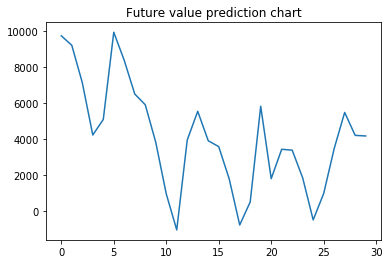

In [ ]:
ax=previsioni_future_prophet.plot()
ax.set_title('Future value prediction chart')
plt.show()

#### Plot expected values vs observed values

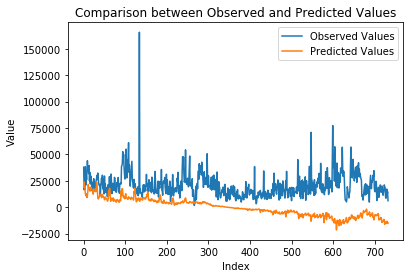

In [ ]:
x = range(len(test_prophet))

# Plot Observed values
plt.plot(x, test_prophet['y'], label='Observed Values')

# Plot Predicted Values
plt.plot(x, yhat_values, label='Predicted Values')

# Customization
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison between Observed and Predicted Values')
plt.legend()

plt.show()

#### Metrics calculation

In [ ]:
yhat_values = forecast['yhat']
# Calcolo delle metriche

mae_Prophet = mean_absolute_error(test_prophet['y'], yhat_values)
mse_Prophet = mean_squared_error(test_prophet['y'], yhat_values)
rmse_Prophet = np.sqrt(mse_Prophet)
mape_Prophet = np.mean(np.abs((test_prophet['y'] - yhat_values) / test_prophet['y'])) * 100


#### Residual analysis

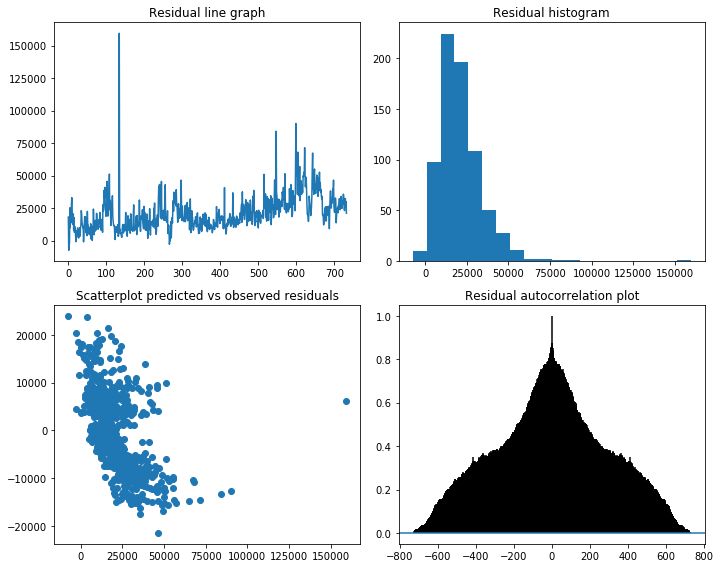

In [ ]:
attesi_prophet=test_prophet['y'].tolist()
predetti_prophet=yhat_values.tolist()
residui_prophet = [x - y for x, y in zip(attesi_prophet, predetti_prophet)]

import matplotlib.pyplot as plt

# Calcola i residui del modello ARIMAX e memorizzali in una lista chiamata 'residui'

# Crea una figura e sottoplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico a linee dei residui
axs[0, 0].plot(residui_prophet)
axs[0, 0].set_title('Residual line graph')

# Istogramma dei residui
axs[0, 1].hist(residui_prophet, bins=20)
axs[0, 1].set_title('Residual histogram')

# Diagramma di dispersione residui previsti vs residui osservati
axs[1, 0].scatter(residui_prophet, predetti_prophet)
axs[1, 0].set_title('Scatterplot predicted vs observed residuals')


# Grafico dell'autocorrelazione residua
axs[1, 1].acorr(residui_prophet, maxlags=len(residui_prophet)-1)
axs[1, 1].set_title('Residual autocorrelation plot')


# Aggiusta la sovrapposizione tra i grafici
plt.tight_layout()

# Mostra il grafico
plt.show()


#### Series decomposition


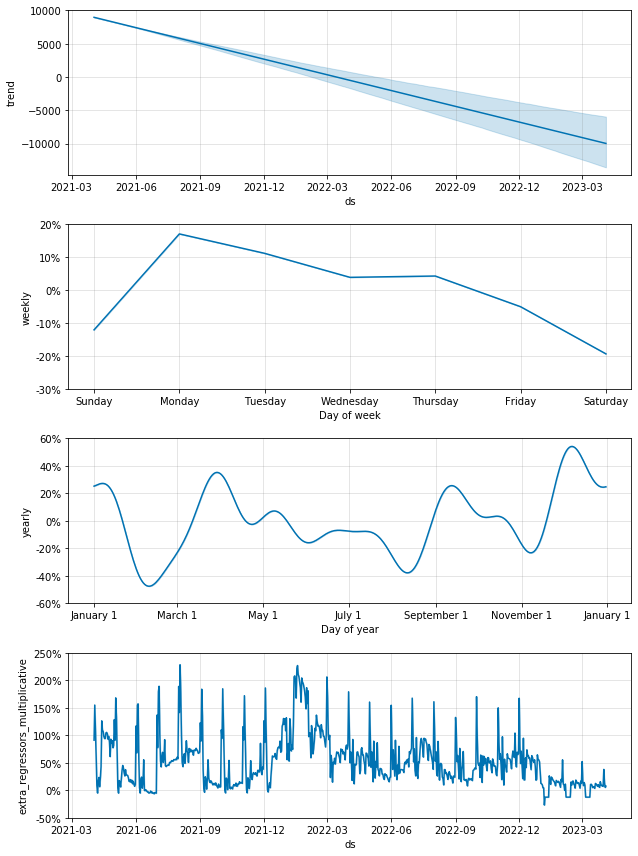

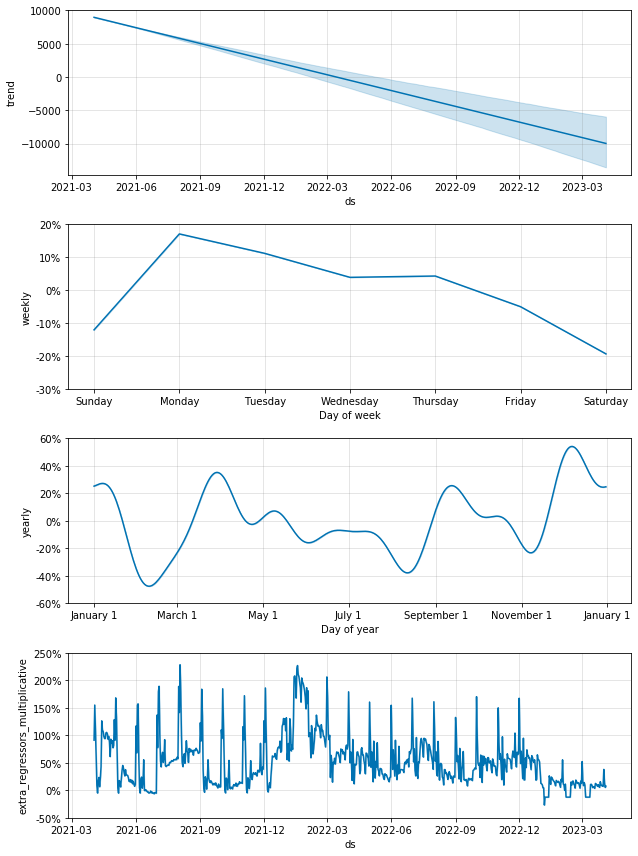

In [ ]:
prophet.plot_components(forecast)

## Linear regression

### Training


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression


# Seleziona le covariate e la variabile dipendente
X = ecommerce_giornaliero[["saldi", "festa", "N_ricoveri"]]
y = ecommerce_giornaliero["Fatturato"]

# Divide il dataset in set di addestramento e di test
train_size = int(len(ecommerce_giornaliero) * 0.8)
X_train_lm, X_test_lm = X[:train_size], X[train_size:]
y_train_lm, y_test_lm = y[:train_size], y[train_size:]

# Crea un oggetto di regressione lineare
lm = LinearRegression()

# Addestra il modello utilizzando le covariate e il fatturato giornaliero
lm.fit(X_train_lm, y_train_lm)

LinearRegression()

#### Prediction on the test set

In [ ]:
# Effettua previsioni sul set di test
predictions_lm = lm.predict(X_test_lm)


#### Prediction for the next 30 days

In [ ]:
df = pd.DataFrame({
      # Sostituisci con i valori dei saldi corrispondenti ai giorni desiderati
    'saldi': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],# Sostituisci con i valori dei ricoveri corrispondenti ai giorni desiderati
    'festa': [0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],  # Sostituisci con i valori delle festività corrispondenti ai giorni desiderati
    'N_ricoveri': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


})

previsioni_future_lm = lm.predict(df)
print(previsioni_future_lm)

[17965.50079803 17965.50079803 17965.50079803 17965.50079803
 17965.50079803 17965.50079803 17965.50079803 17965.50079803
 17965.50079803 17965.50079803 17965.50079803 17048.08708914
 17048.08708914 17965.50079803 17965.50079803 17965.50079803
 17965.50079803 17965.50079803 17965.50079803 17965.50079803
 17048.08708914 17965.50079803 17965.50079803 17965.50079803
 17965.50079803 17965.50079803 17048.08708914 17965.50079803
 17965.50079803 17965.50079803]


#### Observed vs expected plots


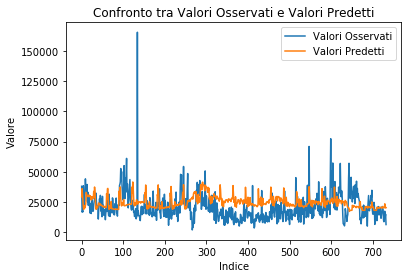

In [ ]:
import matplotlib.pyplot as plt


x = range(len(y_test_lm))

# Plot dei valori osservati
plt.plot(x, y_test_lm, label='Valori Osservati')

# Plot dei valori predetti
plt.plot(x, predictions_lm, label='Valori Predetti')

# Personalizzazione del grafico
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.title('Confronto tra Valori Osservati e Valori Predetti')
plt.legend()

# Mostrare il grafico
plt.show()

#### Metrics calculation

In [ ]:
# Calcolo delle metriche
mae_lm = mean_absolute_error(y_test_lm, predictions_lm)
mse_lm = mean_squared_error(y_test_lm, predictions_lm)
rmse_lm = np.sqrt(mse_lm)
mape_lm = np.mean(np.abs((y_test_lm - predictions_lm) / y_test_lm)) * 100


#### Residual analysis

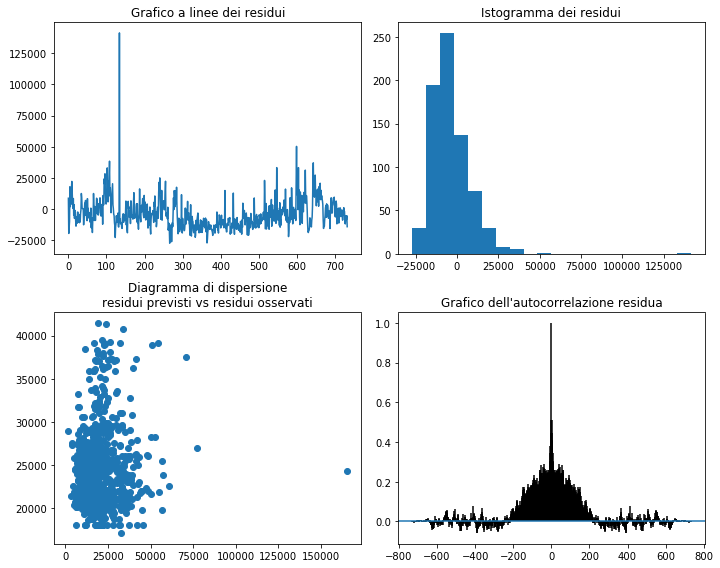

In [ ]:
import matplotlib.pyplot as plt
attesi_lm=y_test_lm.tolist()
predetti_lm=predictions_lm.tolist()
residui_lm = [x - y for x, y in zip(attesi_lm, predetti_lm)]
# Calcola i residui del modello ARIMAX e memorizzali in una lista chiamata 'residui'

# Crea una figura e sottoplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico a linee dei residui
axs[0, 0].plot(residui_lm)
axs[0, 0].set_title('Grafico a linee dei residui')

# Istogramma dei residui
axs[0, 1].hist(residui_lm, bins=20)
axs[0, 1].set_title('Istogramma dei residui')

# Diagramma di dispersione residui previsti vs residui osservati
axs[1, 0].scatter(attesi_lm, predetti_lm)
axs[1, 0].set_title('Diagramma di dispersione\nresidui previsti vs residui osservati')

# Grafico dell'autocorrelazione residua
axs[1, 1].acorr(residui_lm, maxlags=len(residui_lm)-1)
axs[1, 1].set_title('Grafico dell\'autocorrelazione residua')

# Aggiusta la sovrapposizione tra i grafici
plt.tight_layout()

# Mostra il grafico
plt.show()


#### Extract regression coefficients and intercept

In [ ]:
lm.coef_
lm.intercept_

17965.500798025514

## SARIMAX

### Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Carica il dataset

# Dividi il dataset in addestramento e test
train_data, test_data = train_test_split(ecommerce_giornaliero, test_size=0.2, shuffle=False)

# Crea il modello SARIMAX
model = sm.tsa.SARIMAX(train_data['Fatturato'], exog=train_data[['saldi', 'festa', 'N_ricoveri']],
                       order=(3, 0, 4), seasonal_order=(1, 1, 0, 30))

# Addestra il modello
model_fit = model.fit()

# Fai previsioni sul set di test
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1,
                                exog=test_data[['saldi', 'festa', 'N_ricoveri']])

# Calcola l'RMSE
rmse = ((predictions - test_data['Fatturato']) ** 2).mean() ** 0.5

print("RMSE:", rmse)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfr

RMSE: 10053.713118887163


#### Prediction on the test set

In [ ]:
# Fai previsioni sul set di test
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1,
                                exog=test_data[['saldi', 'festa', 'N_ricoveri']])

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### Prediction for the next 30 days

In [ ]:
df = pd.DataFrame({
    'saldi': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # To replace with the values of the balances corresponding to the desired days
    'festa': [0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],  # To replace with the holiday values corresponding to the desired days
    'N_ricoveri': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  # To replace with the values of the hospitalizations corresponding to the desired days
})

previsione_futura_sarimax=model_fit.forecast(steps=len(df), exog=df[['N_ricoveri', 'festa', 'saldi']])
previsione_futura_sarimax

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2929    14953.385893
2930    16830.998418
2931    24819.076303
2932    18577.148838
2933    18260.051598
2934    13922.370062
2935    20693.395990
2936    10337.820499
2937    13177.960694
2938    22996.784055
2939    16582.034823
2940    16079.571308
2941    10930.829474
2942    22993.081515
2943    11067.227403
2944    13996.934688
2945    23408.213529
2946    17452.612297
2947    19503.490352
2948    14618.060166
2949    18544.748003
2950    10785.072504
2951    13614.838509
2952    23233.965476
2953    17157.902074
2954    19639.725208
2955    10946.483009
2956    22518.925662
2957    10868.052197
2958    13726.312972
Name: predicted_mean, dtype: float64

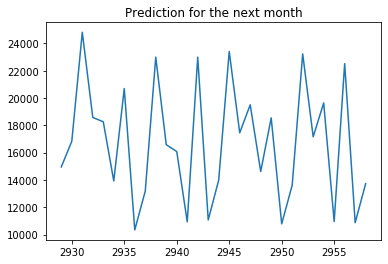

In [ ]:
ax=previsione_futura_sarimax.plot()
ax.set_title('Prediction for the next month')
plt.show()

In [ ]:
coeff = model_fit.params
#coeff_MA = model_fit.maparams# Value of phi for the delayed date Y(t-1)
print(coeff)#,coeff_MA)

saldi         2.528636e+03
festa        -2.588355e+03
N_ricoveri    2.510380e+00
ar.L1        -7.886526e-02
ar.L2         9.232968e-01
ar.L3         3.969555e-02
ma.L1         6.358760e-01
ma.L2        -5.323070e-01
ma.L3        -2.378532e-01
ma.L4        -6.114475e-02
ar.S.L30     -4.916517e-01
sigma2        1.410490e+08
dtype: float64


#### Observed vs expected plots

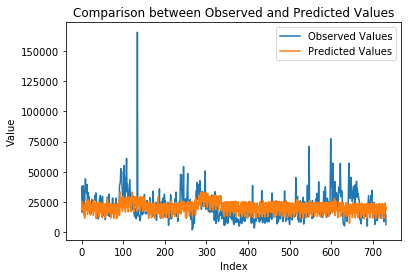

In [ ]:
x = range(len(test_data))

# Plot for the observed values
plt.plot(x, test_data['Fatturato'], label='Observed Values')

# Plot for the predicted values
plt.plot(x, predictions, label='Predicted Values')

# Chart customization
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison between Observed and Predicted Values')
plt.legend()

plt.show()

#### Calculation of evaluation metrics

In [ ]:
# Metrics calculation
mae_sarimax = mean_absolute_error(test_data['Fatturato'], predictions)
mse_sarimax = mean_squared_error(test_data['Fatturato'], predictions)
rmse_sarimax = np.sqrt(mse_sarimax)
mape_sarimax = np.mean(np.abs((test_data['Fatturato'] - predictions) / test_data['Fatturato'])) * 100

#### Residue analysis

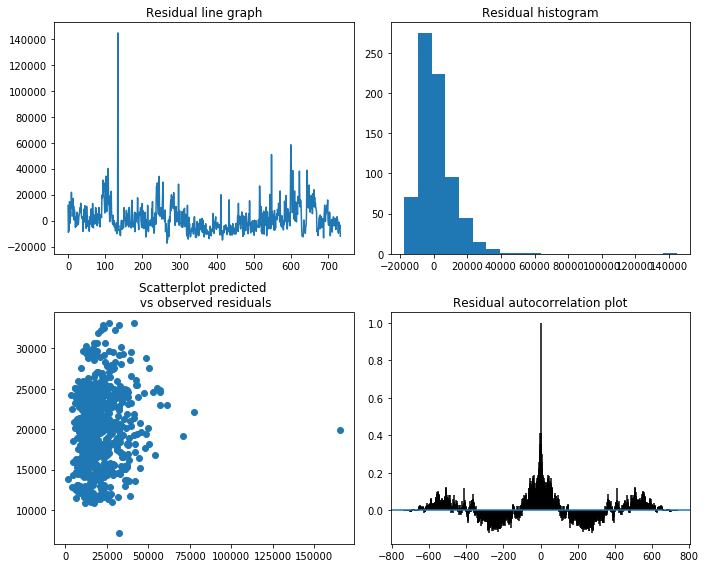

In [ ]:
attesi_sarimax=test_data['Fatturato'].tolist()
predetti_sarimax=predictions.tolist()
residui_sarimax = [x - y for x, y in zip(attesi_arimax, predetti_arimax)]

# Subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Residual line graph
axs[0, 0].plot(residui_sarimax)
axs[0, 0].set_title('Residual line graph')

# Residual Histogram
axs[0, 1].hist(residui_sarimax, bins=20)
axs[0, 1].set_title('Residual histogram')

# Scatterplot predicted residuals vs observed residuals
axs[1, 0].scatter(attesi_sarimax, predetti_sarimax)
axs[1, 0].set_title('Scatterplot predicted \n vs observed residuals')

# Residual autocorrelation plot
axs[1, 1].acorr(residui_sarimax, maxlags=len(residui_sarimax)-1)
axs[1, 1].set_title('Residual autocorrelation plot')


# Layout
plt.tight_layout()

plt.show()


## Comparison of metrics

In [ ]:
import pandas as pd

# Definisci i dati delle metriche per ogni modello
data = {
    'Modello': ['ARIMAX', 'Prophet', 'XgBoost', 'LM','SARIMAX'],
    'MAE': [round(mae_arimax,2), round(mae_Prophet,2), round(mae_XgBoost,2), round(mae_lm,2),round(mae_sarimax,2)],
    'MSE': [round(mse_arimax,2), round(mse_Prophet,2), round(mse_XgBoost,2), round(mse_lm,2),round(mse_sarimax,2)],
    'RMSE': [round(rmse_arimax,2), round(rmse_Prophet,2), round(rmse_XgBoost,2),  round(rmse_lm,2),round(rmse_sarimax,2)],
    'MAPE': [round(mape_arimax,2), round(mape_Prophet,2), round(mape_XgBoost,2), round(mape_lm,2),round(mape_sarimax,2)]
}

# Crea il DataFrame
df = pd.DataFrame(data)

# Imposta la colonna 'Modello' come indice
df.set_index('Modello', inplace=True)

# Stampa il DataFrame
print(df)

              MAE           MSE      RMSE    MAPE
Modello                                          
ARIMAX    7570.03  1.246289e+08  11163.73   49.58
Prophet  21062.97  6.215704e+08  24931.31  101.20
XgBoost  11846.25  2.090145e+08  14457.33   88.32
LM        9706.01  1.594794e+08  12628.52   66.92
SARIMAX   8341.57  1.420094e+08  11916.77   50.88
